<a href="https://colab.research.google.com/github/sydflake/DAEN429-Project/blob/main/hyperparameter_tuning_lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Tuning in Deep Learning with PyTorch and Optuna

## Course: DAEN 429: Hyperparameter Optimization

### Learning Objectives
By the end of this notebook, you will:
1. Understand what hyperparameters are and why they matter
2. Learn the difference between manual and automated hyperparameter tuning
3. Master using Optuna for hyperparameter optimization
4. Implement pruning strategies for efficient search
5. Visualize and interpret optimization results

---

## 1. Introduction: What are Hyperparameters?

### Parameters vs Hyperparameters

**Parameters** are values that the model learns during training:
- Weights and biases in neural networks
- Learned through backpropagation
- Updated during training

**Hyperparameters** are values that we set before training:
- Learning rate
- Number of layers
- Number of neurons per layer
- Batch size
- Optimizer choice (Adam, SGD, etc.)
- Dropout rate

### Why is Hyperparameter Tuning Important?

The choice of hyperparameters can dramatically affect:
- Model performance (accuracy, loss)
- Training speed
- Model generalization
- Risk of overfitting/underfitting

Finding the right combination is often the difference between a mediocre model and a state-of-the-art one!

## 2. Installation and Setup

First, let's install and import the necessary libraries.

In [ ]:
# Install required packages
!pip install torch torchvision optuna plotly

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import optuna
from optuna.trial import TrialState
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.8.0+cu126
Optuna version: 4.6.0
CUDA available: True
Using device: cuda


## 3. Manual Hyperparameter Tuning (The Traditional Way)

Let's first see how we would traditionally tune hyperparameters manually. This will help us appreciate the power of automated methods.

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [ ]:
# Manual hyperparameter tuning - trying different combinations
class SimpleNet(nn.Module):
    def __init__(self, hidden_size=128, n_layers=2, dropout_rate=0.2):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()

        layers = []
        input_size = 28 * 28

        for i in range(n_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_size = hidden_size

        layers.append(nn.Linear(hidden_size, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

# Function to train and evaluate a model with given hyperparameters
def train_and_evaluate(hidden_size, n_layers, learning_rate, batch_size, epochs=5):
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = SimpleNet(hidden_size=hidden_size, n_layers=n_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / len(test_loader.dataset)
    return accuracy

# Manual grid search (this is tedious!)
manual_results = []
hyperparameter_configs = [
    {'hidden_size': 64, 'n_layers': 1, 'learning_rate': 0.001, 'batch_size': 64},
    {'hidden_size': 128, 'n_layers': 2, 'learning_rate': 0.001, 'batch_size': 64},
    {'hidden_size': 256, 'n_layers': 2, 'learning_rate': 0.01, 'batch_size': 128},
]

print("Manual Hyperparameter Search Results:")
print("="*60)
for i, config in enumerate(hyperparameter_configs):
    print(f"\nTrying configuration {i+1}/{len(hyperparameter_configs)}:")
    print(f"Config: {config}")
    accuracy = train_and_evaluate(**config, epochs=3)
    manual_results.append((config, accuracy))
    print(f"Accuracy: {accuracy:.4f}")

# Find best configuration
best_config = max(manual_results, key=lambda x: x[1])
print(f"\nBest manual configuration: {best_config[0]}")
print(f"Best accuracy: {best_config[1]:.4f}")

Manual Hyperparameter Search Results:

Trying configuration 1/3:
Config: {'hidden_size': 64, 'n_layers': 1, 'learning_rate': 0.001, 'batch_size': 64}
Accuracy: 0.9664

Trying configuration 2/3:
Config: {'hidden_size': 128, 'n_layers': 2, 'learning_rate': 0.001, 'batch_size': 64}
Accuracy: 0.9671

Trying configuration 3/3:
Config: {'hidden_size': 256, 'n_layers': 2, 'learning_rate': 0.01, 'batch_size': 128}
Accuracy: 0.9472

Best manual configuration: {'hidden_size': 128, 'n_layers': 2, 'learning_rate': 0.001, 'batch_size': 64}
Best accuracy: 0.9671


## 4. Introduction to Optuna

### What is Optuna?

Optuna is a hyperparameter optimization framework that:
- **Automatically** searches for the best hyperparameters
- Uses **Bayesian optimization** (Tree-structured Parzen Estimator)
- Supports **pruning** to stop unpromising trials early
- Provides **visualizations** to understand the optimization process

### Key Concepts in Optuna

1. **Study**: An optimization session (collection of trials)
2. **Trial**: A single run with a specific set of hyperparameters
3. **Objective Function**: The function we want to optimize (minimize or maximize)
4. **Sampler**: Algorithm that suggests hyperparameters (e.g., TPE, Random, Grid)
5. **Pruner**: Algorithm that stops unpromising trials early

## 5. Building an Objective Function with Optuna

The objective function is the heart of Optuna optimization. It:
1. Receives a `trial` object from Optuna
2. Uses the trial to suggest hyperparameters
3. Trains the model with those hyperparameters
4. Returns a metric to optimize (accuracy, loss, etc.)

In [ ]:
def create_model(trial):
    """
    Create a PyTorch model with hyperparameters suggested by Optuna.

    This function demonstrates how to use Optuna's trial object to:
    - Suggest integer values (n_layers, n_units)
    - Suggest float values (dropout_rate)
    - Build a dynamic architecture based on suggestions
    """
    # Suggest number of layers (1 to 3)
    n_layers = trial.suggest_int('n_layers', 1, 3)

    layers = [nn.Flatten()]
    in_features = 28 * 28

    # Build layers dynamically
    for i in range(n_layers):
        # Suggest number of units for this layer
        out_features = trial.suggest_int(f'n_units_l{i}', 32, 256, step=32)

        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())

        # Suggest dropout rate
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.1, 0.5)
        layers.append(nn.Dropout(dropout_rate))

        in_features = out_features

    # Output layer
    layers.append(nn.Linear(in_features, 10))

    return nn.Sequential(*layers)

def objective(trial):
    """
    Objective function for Optuna optimization.

    This function:
    1. Suggests hyperparameters using the trial object
    2. Creates and trains a model with those hyperparameters
    3. Returns the validation accuracy for Optuna to optimize
    """

    # Suggest hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    # Create model
    model = create_model(trial).to(device)

    # Create optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    # Training loop
    n_epochs = 10
    for epoch in range(n_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / len(val_loader.dataset)

        # Report intermediate value for pruning
        trial.report(accuracy, epoch)

        # Handle pruning
        if trial.should_prune():
            raise optuna.TrialPruned()

    return accuracy

## 6. Running Optuna Optimization

Now let's run the optimization! We'll use:
- **TPE Sampler**: Tree-structured Parzen Estimator for intelligent sampling
- **Median Pruner**: Prunes trials performing worse than median at similar stages

In [ ]:
# Create a study object
study = optuna.create_study(
    study_name='mnist_optimization',
    direction='maximize',  # We want to maximize accuracy
    sampler=optuna.samplers.TPESampler(seed=42),  # Bayesian optimization
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

print("Starting Optuna optimization...")
print("This will run 20 trials. Each trial tests different hyperparameters.")
print("Watch as Optuna learns which hyperparameters work best!\n")

# Run optimization
study.optimize(
    objective,
    n_trials=20,
    timeout=3000,  # 50 minutes timeout
    show_progress_bar=True
)

print("\nOptimization complete!")

[I 2025-11-13 01:34:46,453] A new study created in memory with name: mnist_optimization


Starting Optuna optimization...
This will run 20 trials. Each trial tests different hyperparameters.
Watch as Optuna learns which hyperparameters work best!



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-13 01:37:15,978] Trial 0 finished with value: 0.9634 and parameters: {'batch_size': 64, 'learning_rate': 4.207988669606632e-05, 'optimizer': 'RMSprop', 'n_layers': 2, 'n_units_l0': 192, 'dropout_l0': 0.10823379771832098, 'n_units_l1': 256, 'dropout_l1': 0.4329770563201687}. Best is trial 0 with value: 0.9634.
[I 2025-11-13 01:39:13,732] Trial 1 finished with value: 0.9751 and parameters: {'batch_size': 256, 'learning_rate': 0.0012561043700013551, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.2465447373174767}. Best is trial 1 with value: 0.9751.
[I 2025-11-13 01:41:31,416] Trial 2 finished with value: 0.974 and parameters: {'batch_size': 64, 'learning_rate': 0.00234238498471129, 'optimizer': 'SGD', 'n_layers': 1, 'n_units_l0': 256, 'dropout_l0': 0.4862528132298237}. Best is trial 1 with value: 0.9751.
[I 2025-11-13 01:44:28,266] Trial 3 finished with value: 0.9612 and parameters: {'batch_size': 32, 'learning_rate': 0.00057624872164786, 'optimizer':

## 7. Analyzing Results

After optimization, we can analyze:
- Best hyperparameters found
- Trial history
- Parameter importance
- Optimization visualizations

In [ ]:
# Get the best trial
print("="*60)
print("BEST TRIAL RESULTS")
print("="*60)

best_trial = study.best_trial
print(f"\nBest accuracy: {best_trial.value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Trial statistics
print(f"\n" + "="*60)
print("OPTIMIZATION STATISTICS")
print("="*60)

print(f"Number of finished trials: {len(study.trials)}")
print(f"Number of pruned trials: {len(study.get_trials(deepcopy=False, states=[TrialState.PRUNED]))}")
print(f"Number of complete trials: {len(study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]))}")

# Show all trials sorted by value
print(f"\n" + "="*60)
print("TOP 5 TRIALS")
print("="*60)

trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values('value', ascending=False).head(5)
print(trials_df[['number', 'value', 'params_optimizer', 'params_learning_rate', 'params_batch_size']])

BEST TRIAL RESULTS

Best accuracy: 0.9817

Best hyperparameters:
  batch_size: 256
  learning_rate: 0.0006079008510564345
  optimizer: Adam
  n_layers: 2
  n_units_l0: 192
  dropout_l0: 0.2798322316893283
  n_units_l1: 192
  dropout_l1: 0.21133493651249324

OPTIMIZATION STATISTICS
Number of finished trials: 20
Number of pruned trials: 14
Number of complete trials: 6

TOP 5 TRIALS
    number   value params_optimizer  params_learning_rate  params_batch_size
19      19  0.9817             Adam              0.000608                256
1        1  0.9751          RMSprop              0.001256                256
2        2  0.9740              SGD              0.002342                 64
4        4  0.9700             Adam              0.002464                 32
0        0  0.9634          RMSprop              0.000042                 64


## 8. Visualization of Optimization Process

Optuna provides powerful visualization tools to understand the optimization process.

In [ ]:
# Plot optimization history
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(title="Optimization History: How Accuracy Improved Over Trials")
fig.show()

print("This plot shows how the best accuracy improved over trials.")
print("Notice how Optuna quickly finds good hyperparameters!")

This plot shows how the best accuracy improved over trials.
Notice how Optuna quickly finds good hyperparameters!


In [ ]:
# Plot parameter importances
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(title="Hyperparameter Importance: Which Parameters Matter Most?")
fig.show()

print("This plot shows which hyperparameters have the biggest impact on performance.")
print("Focus your attention on the most important ones!")

This plot shows which hyperparameters have the biggest impact on performance.
Focus your attention on the most important ones!


In [ ]:
# Plot parallel coordinate plot
fig = optuna.visualization.plot_parallel_coordinate(
    study,
    params=['optimizer', 'learning_rate', 'batch_size']
)
fig.update_layout(title="Parallel Coordinates: Relationship Between Parameters and Performance")
fig.show()

print("This plot shows how different combinations of hyperparameters affect accuracy.")
print("Lines are colored by accuracy - red is better!")

This plot shows how different combinations of hyperparameters affect accuracy.
Lines are colored by accuracy - red is better!


In [ ]:
# Plot slice plot
fig = optuna.visualization.plot_slice(study)
fig.update_layout(title="Slice Plot: Individual Parameter Effects")
fig.show()

print("This plot shows how each hyperparameter individually affects the objective.")
print("Look for patterns to understand optimal ranges!")

This plot shows how each hyperparameter individually affects the objective.
Look for patterns to understand optimal ranges!


## 9. Advanced: Implementing Pruning for Efficiency

Pruning stops unpromising trials early, saving computational resources. Let's see it in action!

In [ ]:
def objective_with_detailed_pruning(trial):
    """
    Enhanced objective function with detailed pruning feedback.
    """
    # Hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # Create simple model for demonstration
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10)
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    n_epochs = 10
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / len(val_loader.dataset)

        # Report intermediate value
        trial.report(accuracy, epoch)

        # Check if we should prune
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch} with accuracy {accuracy:.4f}")
            raise optuna.TrialPruned()

    return accuracy

# Create study with aggressive pruning
pruning_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=3,  # Don't prune first 3 trials
        n_warmup_steps=2,    # Don't prune first 2 epochs
        interval_steps=1     # Check for pruning every epoch
    )
)

print("Running optimization with pruning...")
print("Watch for trials being pruned early!\n")

pruning_study.optimize(
    objective_with_detailed_pruning,
    n_trials=15,
    show_progress_bar=True
)

print(f"\nCompleted trials: {len(pruning_study.get_trials(states=[TrialState.COMPLETE]))}")
print(f"Pruned trials: {len(pruning_study.get_trials(states=[TrialState.PRUNED]))}")
print(f"Time saved by pruning: ~{len(pruning_study.get_trials(states=[TrialState.PRUNED])) * 5} epochs worth of training!")

[I 2025-11-13 02:07:41,089] A new study created in memory with name: no-name-291b0003-e0c3-4cd3-94a0-ed6915894440


Running optimization with pruning...
Watch for trials being pruned early!



  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-11-13 02:10:01,559] Trial 0 finished with value: 0.974 and parameters: {'batch_size': 64, 'learning_rate': 0.0015751320499779737}. Best is trial 0 with value: 0.974.
[I 2025-11-13 02:12:41,367] Trial 1 finished with value: 0.9576 and parameters: {'batch_size': 32, 'learning_rate': 0.005399484409787433}. Best is trial 0 with value: 0.974.
[I 2025-11-13 02:15:04,575] Trial 2 finished with value: 0.9547 and parameters: {'batch_size': 64, 'learning_rate': 0.008706020878304856}. Best is trial 0 with value: 0.974.
[I 2025-11-13 02:17:43,648] Trial 3 finished with value: 0.9783 and parameters: {'batch_size': 32, 'learning_rate': 0.00023270677083837802}. Best is trial 3 with value: 0.9783.
[I 2025-11-13 02:20:06,134] Trial 4 finished with value: 0.9779 and parameters: {'batch_size': 64, 'learning_rate': 0.0003823475224675188}. Best is trial 3 with value: 0.9783.
[I 2025-11-13 02:22:45,323] Trial 5 finished with value: 0.9812 and parameters: {'batch_size': 32, 'learning_rate': 0.0005404

## 10. Visualizing Pruning: Training Curves Comparison

Now let's create a powerful visualization that shows exactly when and why trials get pruned!

In [ ]:
# Let's create a study that tracks training curves for visualization
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Store training histories
training_histories = defaultdict(list)
trial_statuses = {}  # Track whether each trial was pruned or completed

def objective_with_history(trial):
    """
    Objective function that stores training history for visualization.
    """
    trial_id = trial.number

    # Suggest hyperparameters - some deliberately bad for demonstration
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    hidden_size = trial.suggest_int('hidden_size', 16, 256, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.7)

    # Create a simple model
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size, 10)
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    n_epochs = 15
    for epoch in range(n_epochs):
        # Training
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / len(val_loader.dataset)

        # Store history
        training_histories[trial_id].append(accuracy)

        # Report for pruning
        trial.report(accuracy, epoch)

        # Check pruning
        if trial.should_prune():
            trial_statuses[trial_id] = 'pruned'
            print(f"Trial {trial_id}: PRUNED at epoch {epoch+1} (accuracy: {accuracy:.3f})")
            raise optuna.TrialPruned()

    trial_statuses[trial_id] = 'completed'
    print(f"Trial {trial_id}: COMPLETED (final accuracy: {accuracy:.3f})")
    return accuracy

# Create study with MedianPruner
curve_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.RandomSampler(seed=42),  # Random to get variety
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=3,
        n_warmup_steps=3,
        interval_steps=1
    )
)

print("Running trials to collect training curves...")
print("="*60)
curve_study.optimize(objective_with_history, n_trials=20, show_progress_bar=True)

print(f"\n" + "="*60)
print(f"Completed trials: {sum(1 for s in trial_statuses.values() if s == 'completed')}")
print(f"Pruned trials: {sum(1 for s in trial_statuses.values() if s == 'pruned')}")

[I 2025-11-13 02:34:26,643] A new study created in memory with name: no-name-ff5a27d8-a5ef-44bb-851f-5ce2788ae17f


Running trials to collect training curves...


  0%|          | 0/20 [00:00<?, ?it/s]

Trial 0: COMPLETED (final accuracy: 0.973)
[I 2025-11-13 02:38:29,048] Trial 0 finished with value: 0.9734 and parameters: {'learning_rate': 0.00031489116479568613, 'batch_size': 32, 'hidden_size': 48, 'dropout_rate': 0.04065852851773962}. Best is trial 0 with value: 0.9734.
Trial 1: COMPLETED (final accuracy: 0.887)
[I 2025-11-13 02:41:41,799] Trial 1 finished with value: 0.887 and parameters: {'learning_rate': 0.029154431891537533, 'batch_size': 256, 'hidden_size': 224, 'dropout_rate': 0.1486373774747933}. Best is trial 0 with value: 0.9734.
Trial 2: COMPLETED (final accuracy: 0.940)
[I 2025-11-13 02:44:59,739] Trial 2 finished with value: 0.9399 and parameters: {'learning_rate': 5.3370327626039544e-05, 'batch_size': 128, 'hidden_size': 80, 'dropout_rate': 0.42829702630566563}. Best is trial 0 with value: 0.9734.
Trial 3: PRUNED at epoch 4 (accuracy: 0.868)
[I 2025-11-13 02:45:50,789] Trial 3 pruned. 
Trial 4: COMPLETED (final accuracy: 0.950)
[I 2025-11-13 02:49:22,643] Trial 4 fini

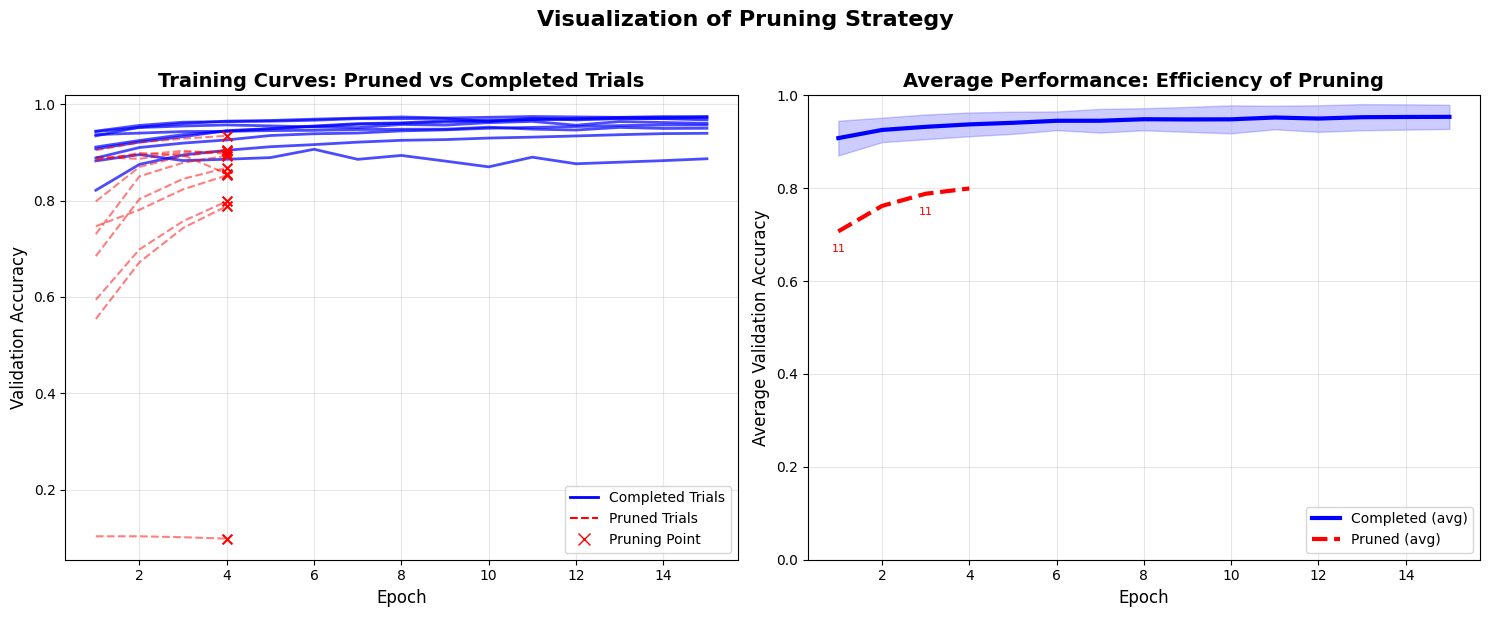


Key Insights from the Visualization:
 RED LINES (Pruned): Trials that were stopped early because they were underperforming
 BLUE LINES (Completed): Trials that ran to completion
 RED X's: Points where trials were pruned

Notice how pruning saves computational resources by stopping bad trials early!


In [ ]:
# Create the training curves visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: All training curves
ax1.set_title('Training Curves: Pruned vs Completed Trials', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Accuracy', fontsize=12)
ax1.grid(True, alpha=0.3)

# Separate pruned and completed trials
for trial_id, history in training_histories.items():
    epochs = list(range(1, len(history) + 1))

    if trial_statuses[trial_id] == 'pruned':
        # Pruned trials - red color, dashed line
        ax1.plot(epochs, history, 'r--', alpha=0.5, linewidth=1.5)
        # Mark the pruning point
        ax1.scatter(epochs[-1], history[-1], color='red', s=50, marker='x', zorder=5)
    else:
        # Completed trials - blue color, solid line
        ax1.plot(epochs, history, 'b-', alpha=0.7, linewidth=2)

# Add legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', linewidth=2, label='Completed Trials'),
    Line2D([0], [0], color='red', linewidth=1.5, linestyle='--', label='Pruned Trials'),
    Line2D([0], [0], marker='x', color='red', linewidth=0, markersize=8, label='Pruning Point')
]
ax1.legend(handles=legend_elements, loc='lower right')

# Plot 2: Average performance comparison
ax2.set_title('Average Performance: Efficiency of Pruning', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Average Validation Accuracy', fontsize=12)
ax2.grid(True, alpha=0.3)

# Calculate average curves
max_epochs = max(len(h) for h in training_histories.values())
pruned_curves = [h for tid, h in training_histories.items() if trial_statuses[tid] == 'pruned']
completed_curves = [h for tid, h in training_histories.items() if trial_statuses[tid] == 'completed']

# Calculate averages for completed trials
if completed_curves:
    avg_completed = []
    std_completed = []
    for epoch in range(max_epochs):
        values = [c[epoch] for c in completed_curves if epoch < len(c)]
        if values:
            avg_completed.append(np.mean(values))
            std_completed.append(np.std(values))

    epochs_range = range(1, len(avg_completed) + 1)
    ax2.plot(epochs_range, avg_completed, 'b-', linewidth=3, label='Completed (avg)')
    ax2.fill_between(epochs_range,
                     np.array(avg_completed) - np.array(std_completed),
                     np.array(avg_completed) + np.array(std_completed),
                     alpha=0.2, color='blue')

# Calculate averages for pruned trials
if pruned_curves:
    # Show how many trials were active at each epoch
    trials_per_epoch = []
    avg_pruned = []
    for epoch in range(max_epochs):
        values = [c[epoch] for c in pruned_curves if epoch < len(c)]
        if values:
            avg_pruned.append(np.mean(values))
            trials_per_epoch.append(len(values))
        else:
            break

    epochs_range = range(1, len(avg_pruned) + 1)
    ax2.plot(epochs_range, avg_pruned, 'r--', linewidth=3, label='Pruned (avg)')

    # Add text showing number of active trials
    for i, (epoch, n_trials) in enumerate(zip(epochs_range, trials_per_epoch)):
        if i % 2 == 0:  # Show every other epoch to avoid clutter
            ax2.annotate(f'{n_trials}', xy=(epoch, avg_pruned[i]),
                        xytext=(0, -15), textcoords='offset points',
                        fontsize=8, color='red', ha='center')

ax2.legend(loc='lower right')
ax2.set_ylim([0, 1])

plt.suptitle('Visualization of Pruning Strategy', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nKey Insights from the Visualization:")
print("="*60)
print(" RED LINES (Pruned): Trials that were stopped early because they were underperforming")
print(" BLUE LINES (Completed): Trials that ran to completion")
print(" RED X's: Points where trials were pruned")
print("\nNotice how pruning saves computational resources by stopping bad trials early!")

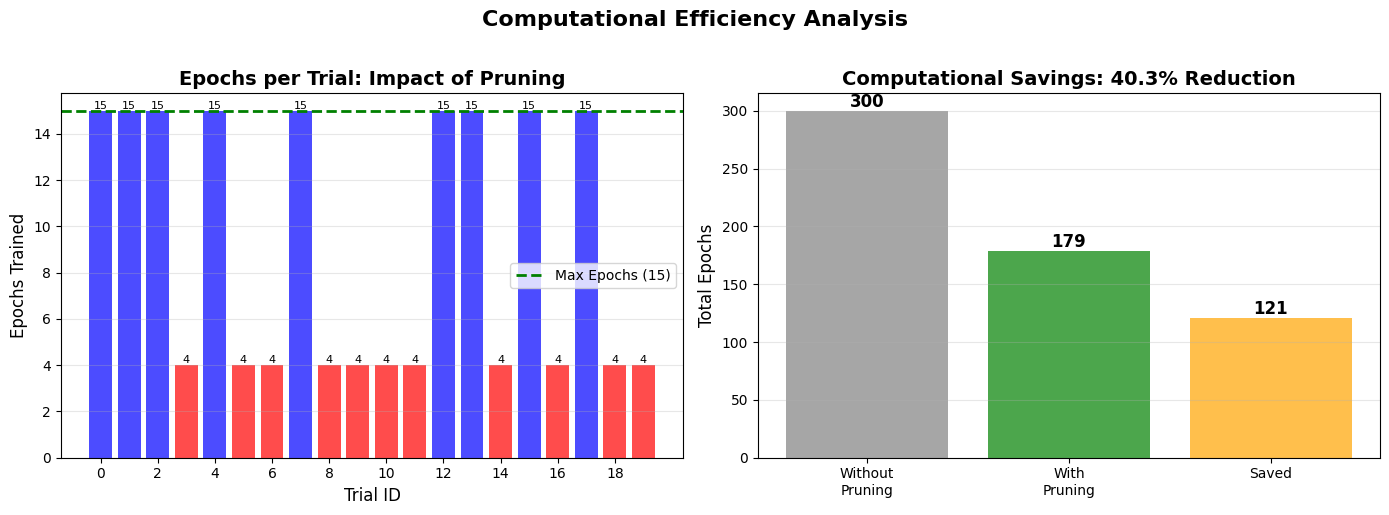


COMPUTATIONAL SAVINGS SUMMARY
Total trials run: 20
Completed trials: 9
Pruned trials: 11

Epochs without pruning: 300
Epochs with pruning: 179
Epochs saved: 121

🎯 Efficiency Gain: 40.3% reduction in training time!

Average pruning epoch: 4.0
Earliest pruning: Epoch 4
Latest pruning: Epoch 4


In [ ]:
# Create a detailed analysis of computational savings
total_possible_epochs = 15 * len(training_histories)  # max epochs * number of trials
actual_epochs = sum(len(h) for h in training_histories.values())
saved_epochs = total_possible_epochs - actual_epochs
savings_percentage = (saved_epochs / total_possible_epochs) * 100

# Create a bar plot showing computational savings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Epochs per trial
trial_ids = list(training_histories.keys())
epochs_per_trial = [len(h) for h in training_histories.values()]
colors = ['red' if trial_statuses[tid] == 'pruned' else 'blue' for tid in trial_ids]

bars = ax1.bar(range(len(trial_ids)), epochs_per_trial, color=colors, alpha=0.7)
ax1.axhline(y=15, color='green', linestyle='--', linewidth=2, label='Max Epochs (15)')
ax1.set_xlabel('Trial ID', fontsize=12)
ax1.set_ylabel('Epochs Trained', fontsize=12)
ax1.set_title('Epochs per Trial: Impact of Pruning', fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, len(trial_ids), 2))
ax1.set_xticklabels(trial_ids[::2])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, epochs in zip(bars, epochs_per_trial):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(epochs)}', ha='center', va='bottom', fontsize=8)

# Plot 2: Computational savings summary
categories = ['Without\nPruning', 'With\nPruning', 'Saved']
values = [total_possible_epochs, actual_epochs, saved_epochs]
colors_summary = ['gray', 'green', 'orange']

bars2 = ax2.bar(categories, values, color=colors_summary, alpha=0.7)
ax2.set_ylabel('Total Epochs', fontsize=12)
ax2.set_title(f'Computational Savings: {savings_percentage:.1f}% Reduction', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars2, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(value)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.suptitle('Computational Efficiency Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("COMPUTATIONAL SAVINGS SUMMARY")
print("="*60)
print(f"Total trials run: {len(training_histories)}")
print(f"Completed trials: {sum(1 for s in trial_statuses.values() if s == 'completed')}")
print(f"Pruned trials: {sum(1 for s in trial_statuses.values() if s == 'pruned')}")
print(f"\nEpochs without pruning: {total_possible_epochs}")
print(f"Epochs with pruning: {actual_epochs}")
print(f"Epochs saved: {saved_epochs}")
print(f"\n🎯 Efficiency Gain: {savings_percentage:.1f}% reduction in training time!")

# Calculate average stopping epoch for pruned trials
pruned_epochs = [len(training_histories[tid]) for tid, status in trial_statuses.items() if status == 'pruned']
if pruned_epochs:
    print(f"\nAverage pruning epoch: {np.mean(pruned_epochs):.1f}")
    print(f"Earliest pruning: Epoch {min(pruned_epochs)}")
    print(f"Latest pruning: Epoch {max(pruned_epochs)}")

## 11. Best Practices and Tips

### Do's

1. **Start with a smaller search space**: Begin with reasonable ranges
2. **Use appropriate samplers**:
   - TPESampler for general optimization
   - RandomSampler for initial exploration
   - GridSampler when you have specific values to test
3. **Enable pruning** for expensive objectives
4. **Log intermediate values** with `trial.report()`
5. **Save your study** for later analysis
6. **Use categorical suggestions** for discrete choices
7. **Use log-uniform** for parameters that vary by orders of magnitude

### Don'ts

1. **Don't use too many trials** initially - start small
2. **Don't ignore pruned trials** - they provide valuable information
3. **Don't forget to set seeds** for reproducibility
4. **Don't use uniform sampling** for learning rates
5. **Don't optimize too many hyperparameters** at once

## 12. Summary and Key Takeaways

### What We Learned

1. **Hyperparameters vs Parameters**:
   - Parameters are learned during training
   - Hyperparameters are set before training

2. **Why Automated Tuning Matters**:
   - Manual tuning is time-consuming and inefficient
   - Automated methods explore the space more intelligently

3. **Optuna's Key Features**:
   - **Objective Function**: Defines what to optimize
   - **Trial Object**: Suggests hyperparameters
   - **TPE Sampler**: Uses Bayesian optimization
   - **Pruning**: Stops bad trials early

4. **Best Practices**:
   - Use log-uniform for learning rates
   - Enable pruning for efficiency
   - Visualize results to understand patterns
   - Start with reasonable search spaces

### Resources

- [Optuna Documentation](https://optuna.readthedocs.io/)
- [Optuna GitHub](https://github.com/optuna/optuna)
- [PyTorch Documentation](https://pytorch.org/docs/)
- [Research Paper on TPE](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)